# Functional API
In this notebook we will inversitgate some features of functional API for creating models and see some applications

## Loading MNIST dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
ds, info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


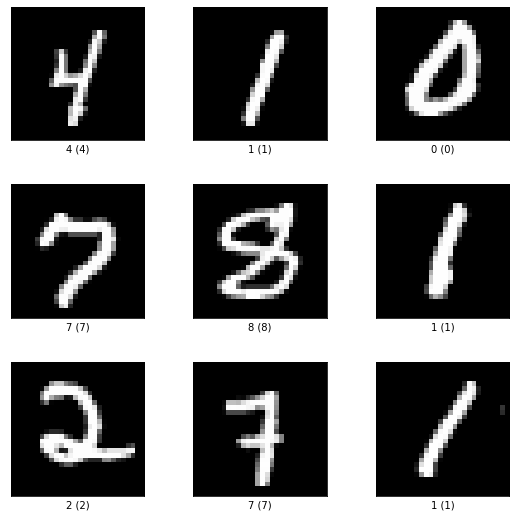

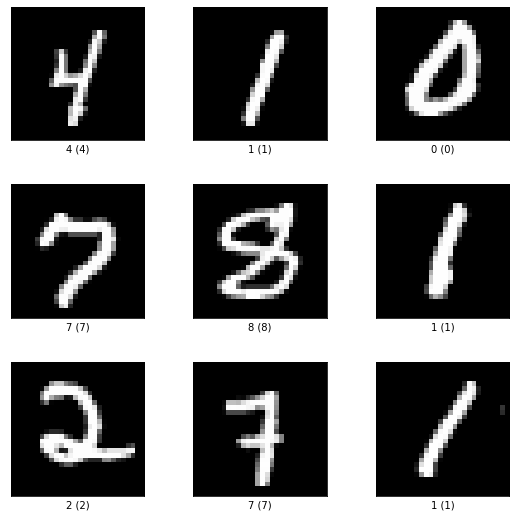

In [3]:
tfds.visualization.show_examples(ds[0], info)

In [4]:
ds_train = ds[0]
ds_test = ds[1]

In [5]:
def preprocess_dataset(img, label):
    img = tf.divide(tf.cast(img, tf.float32), 255.)
    encoded_label = tf.one_hot(label, depth=10)
    return img, encoded_label

In [6]:
ds_train = ds_train.map(preprocess_dataset)
ds_test = ds_test.map(preprocess_dataset)

In [7]:
input_shape = (28, 28, 1)
num_classes = 10

input = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", name="first_conv")(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
pred = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input, outputs=pred)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 first_conv (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0     

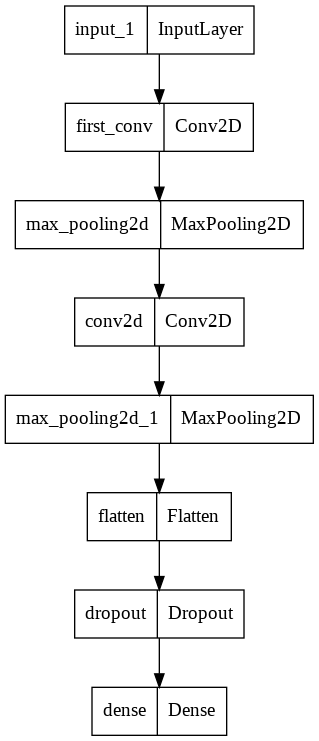

In [9]:
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", #show_shapes=True
                          )

In [10]:
ds_train = ds_train.shuffle(1000).batch(64)
ds_test = ds_test.batch(64)

In [11]:
next(iter(ds_train.take(1)))[1].shape

TensorShape([64, 10])

In [12]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(ds_train, epochs=2)

test_scores = model.evaluate(ds_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


938/938 [==============================] - 19s 8ms/step - loss: 0.2531 - accuracy: 0.9219
Epoch 2/2
938/938 [==============================] - 6s 6ms/step - loss: 0.0919 - accuracy: 0.9718
157/157 - 1s - loss: 0.0680 - accuracy: 0.9786 - 1s/epoch - 7ms/step
Test loss: 0.0679648295044899
Test accuracy: 0.978600025177002


## Models with Complex Topology
https://keras.io/guides/functional_api/

The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the Sequential API.

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

* the title of the ticket (text input),
* the text body of the ticket (text input), and
* any tags added by the user (categorical input)
This model will have two outputs:

the priority score between 0 and 1 (scalar sigmoid output), and
the department that should handle the ticket (softmax output over the set of departments).

In [13]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

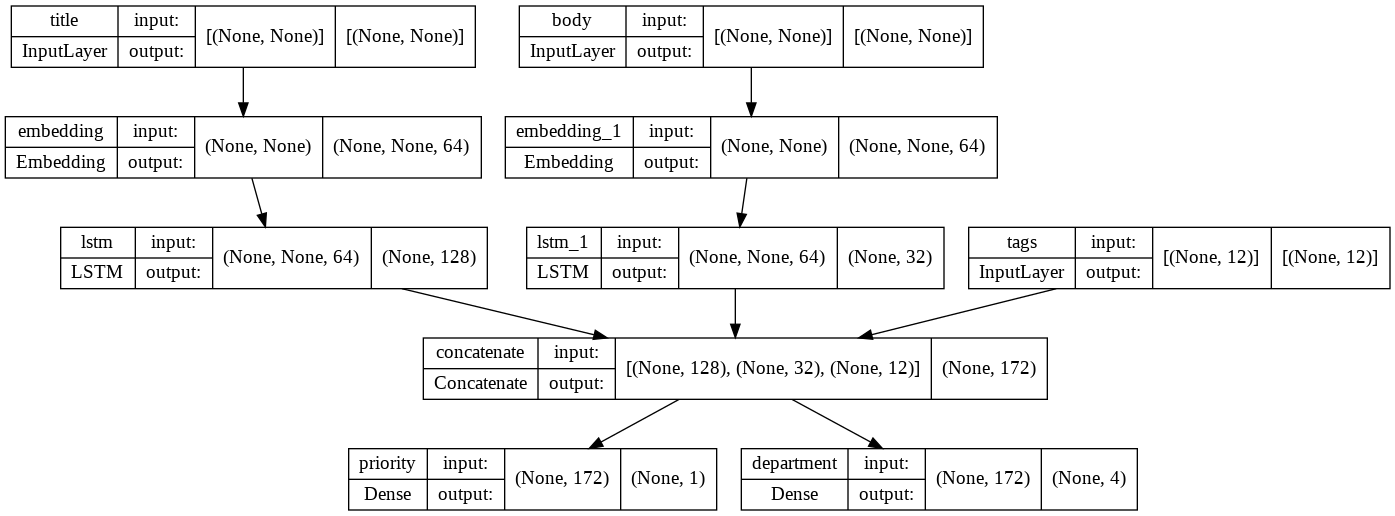

In [14]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output. You can even assign different weights to each loss -- to modulate their contribution to the total training loss.

In [15]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

In [16]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

In [17]:
# Dummy input data
import numpy as np
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 4s 11ms/step - loss: 1.2715 - priority_loss: 0.7028 - department_loss: 2.8436
Epoch 2/2
40/40 [==============================] - 0s 10ms/step - loss: 1.2591 - priority_loss: 0.6979 - department_loss: 2.8062


## A toy ResNet model

In addition to models with multiple inputs and outputs, the functional API makes it easy to manipulate non-linear connectivity topologies -- these are models with layers that are not connected sequentially, which the Sequential API cannot handle.

A common use case for this is residual connections. Let's build a toy ResNet model for CIFAR10 to demonstrate this:

In [18]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_1[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_2[0][0]']               
                                                                                         

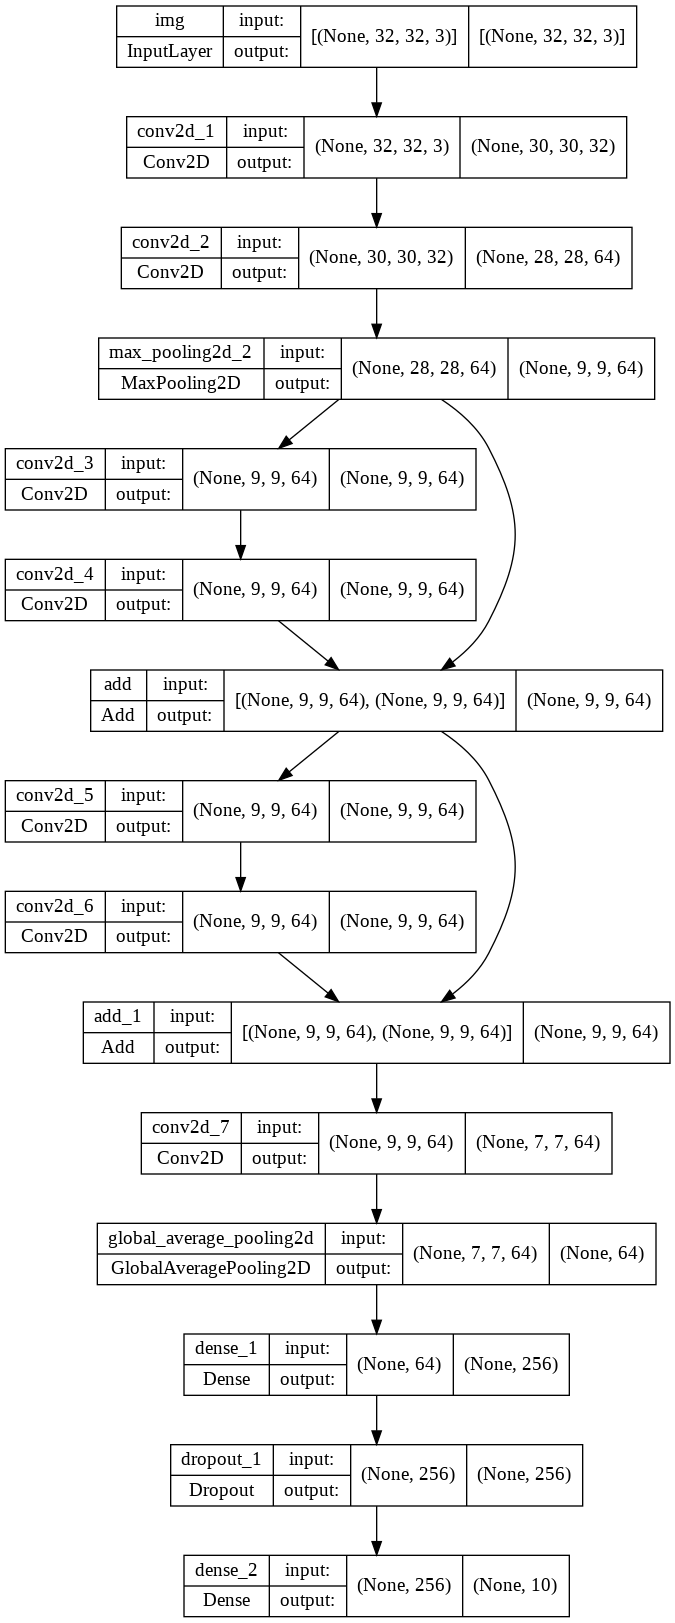

In [19]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [20]:
ds, info = tfds.load("cifar10", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteQ8AS21/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteQ8AS21/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


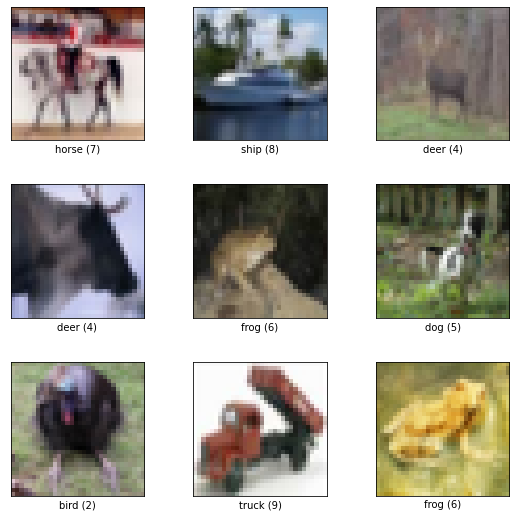

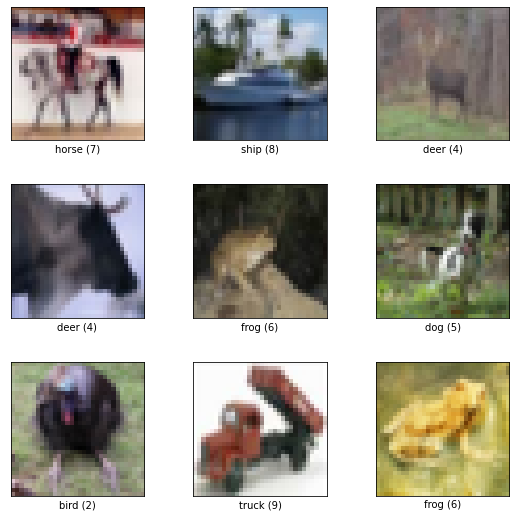

In [21]:
tfds.visualization.show_examples(ds[0], info)

In [22]:
ds_train = ds[0]
ds_val = ds[1]
ds_test = ds[2]

In [23]:
ds_train = ds_train.map(preprocess_dataset).shuffle(1000).batch(64)
ds_val = ds_val.map(preprocess_dataset).batch(64)
ds_test = ds_test.map(preprocess_dataset).batch(64)



In [24]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(ds_train, validation_data=ds_val, epochs=1)

625/625 [==============================] - 14s 20ms/step - loss: 1.9128 - acc: 0.2797 - val_loss: 1.7318 - val_acc: 0.3735
